In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import random
import seaborn as sns
from numpy import array

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

#import statsmodels as sm
#import statsmodels.api as smt
#from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import tensorflow as tf

np.random.seed(1) 
tf.random.set_seed(1) 
random.seed(1)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16,5

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Import and Preprocess 

In [ ]:
!fusermount -u drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Change directory
% cd '/content/drive/'

/content/drive


In [ ]:
# Import data

#dateparse = lambda dates: pd.datetime.strptime(dates, '%b-%y')
data = pd.read_csv('/content/drive/My Drive/unemployment-rate-1948-2021.csv',
                   parse_dates=['yearmonth'], 
                   index_col='yearmonth')

ts_all = data['unemployment rate']
dataG = pd.read_csv('/content/drive/My Drive/GDP-1947-2021Q1.csv',
                   parse_dates=['date'], 
                   index_col='date')
dataG = dataG.rename_axis("yearmonth")

In [ ]:
ts_all.head()

yearmonth
1948-01-01    3.4
1948-02-01    3.8
1948-03-01    4.0
1948-04-01    3.9
1948-05-01    3.5
Name: unemployment rate, dtype: float64

In [ ]:
# liner interpolate for GDP data
df = dataG.copy()
df = df.resample('1M').mean()
df['month_change'] = df[['month_change']].interpolate(method="linear")
df

,GDP,month_change
yearmonth,,
1947-02-28,243.164,0.000000
1947-03-31,NaN,0.310000
1947-04-30,NaN,0.620000
1947-05-31,245.968,0.930000
1947-06-30,NaN,1.023333
...,...,...
2020-10-31,NaN,255.456667
2020-11-30,21494.731,108.160000
2020-12-31,NaN,135.080000


In [ ]:
gdp_all = df['month_change']
gdp_all.head()

yearmonth
1947-02-28    0.000000
1947-03-31    0.310000
1947-04-30    0.620000
1947-05-31    0.930000
1947-06-30    1.023333
Name: month_change, dtype: float64

In [ ]:
# Descriptive stats for unemployment rate

ts_all.describe()

count    882.000000
mean       5.768594
std        1.701312
min        2.500000
25%        4.500000
50%        5.600000
75%        6.800000
max       14.800000
Name: unemployment rate, dtype: float64

In [ ]:
# Descriptive stats for GDP

gdp_all.describe()

count    889.000000
mean      24.330157
std       47.838959
min     -680.340000
25%        4.100000
50%       19.570000
75%       38.890000
max      550.050000
Name: month_change, dtype: float64

In [ ]:
# Check is there any missing value in time series

if data.isnull().values.any():
    print("Having missing values")
else:
   print("No missing values")

if gdp_all.isnull().values.any():
    print("Having missing values")
else:
   print("No missing values")

No missing values
No missing values


Text(0, 0.5, 'Unemployment Rate (%)')

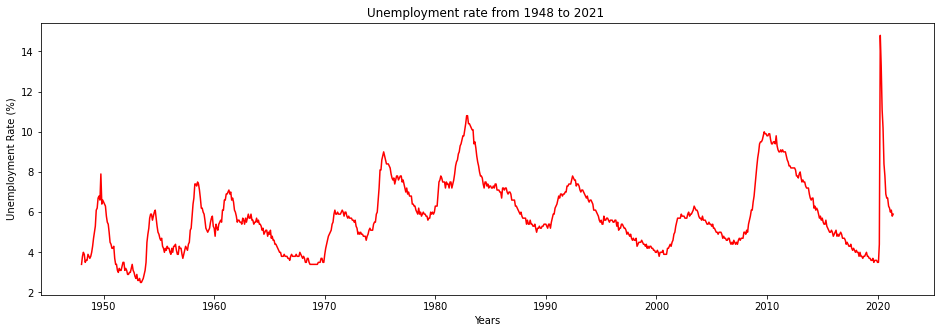

In [ ]:
plt.figure(figsize=(16, 5)) 
plt.plot(ts_all,'r-') 
plt.title('Unemployment rate from 1948 to 2021 ') 
plt.xlabel('Years') 
plt.ylabel('Unemployment Rate (%)')

Text(0, 0.5, 'GDP change')

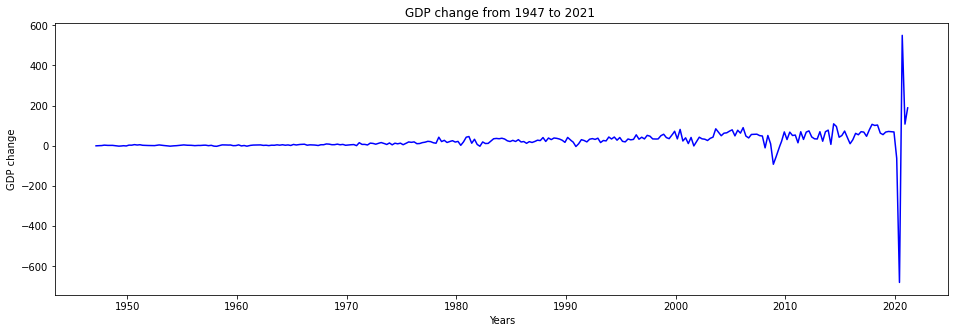

In [ ]:
plt.figure(figsize=(16, 5)) 
plt.plot(gdp_all,'b-') 
plt.title('GDP change from 1947 to 2021 ') 
plt.xlabel('Years') 
plt.ylabel('GDP change')

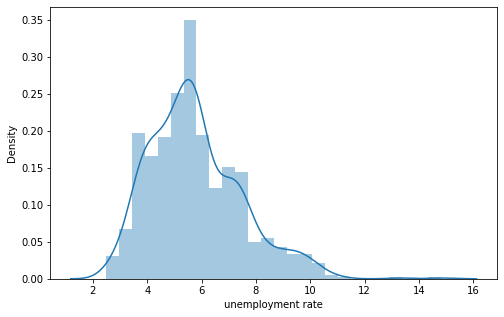

In [ ]:
# Check data distribution

plt.figure(figsize=(8, 5)) 

sns.distplot(ts_all)

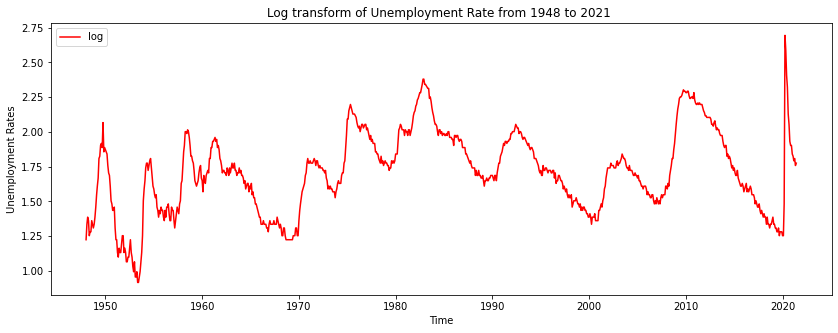

In [ ]:
# Check stationary of time series after using log transformation

ts_log= np.log(ts_all)
plt.figure(figsize=(14, 5)) 
plt.plot(ts_log, color='red',label='log')
plt.title('Log transform of Unemployment Rate from 1948 to 2021 ') 
plt.xlabel('Time')
plt.ylabel('Unemployment Rates')
plt.legend()

In [ ]:
# combine two time series variables into one dataframe
#get rid of 1947 data of gdp
gdp_all = gdp_all[11:]


In [ ]:
#delete feb in 2021
gdp_all = gdp_all[:-1]
gdp_all

yearmonth
1948-01-31      2.463333
1948-02-29      2.000000
1948-03-31      2.093333
1948-04-30      2.186667
1948-05-31      2.280000
                 ...    
2020-09-30    402.753333
2020-10-31    255.456667
2020-11-30    108.160000
2020-12-31    135.080000
2021-01-31    162.000000
Name: month_change, Length: 877, dtype: float64

In [ ]:
#get rid of feb to FEB 2021 data of unemployment rate
ts_all = ts_all[:-5]
ts_all

yearmonth
1948-01-01    3.4
1948-02-01    3.8
1948-03-01    4.0
1948-04-01    3.9
1948-05-01    3.5
             ... 
2020-09-01    7.8
2020-10-01    6.9
2020-11-01    6.7
2020-12-01    6.7
2021-01-01    6.3
Name: unemployment rate, Length: 877, dtype: float64

In [ ]:
gdp_all.index = ts_all.index
gdp_all

yearmonth
1948-01-01      2.463333
1948-02-01      2.000000
1948-03-01      2.093333
1948-04-01      2.186667
1948-05-01      2.280000
                 ...    
2020-09-01    402.753333
2020-10-01    255.456667
2020-11-01    108.160000
2020-12-01    135.080000
2021-01-01    162.000000
Name: month_change, Length: 877, dtype: float64

In [ ]:
from pandas import DataFrame
df = DataFrame()
df['t_ue'] = ts_all
df['t_gdpchange'] = gdp_all
df['t+1_ue'] = df['t_ue'].shift(-1)
print(df)

            t_ue  t_gdpchange  t+1_ue
yearmonth                            
1948-01-01   3.4     2.463333     3.8
1948-02-01   3.8     2.000000     4.0
1948-03-01   4.0     2.093333     3.9
1948-04-01   3.9     2.186667     3.5
1948-05-01   3.5     2.280000     3.6
...          ...          ...     ...
2020-09-01   7.8   402.753333     6.9
2020-10-01   6.9   255.456667     6.7
2020-11-01   6.7   108.160000     6.7
2020-12-01   6.7   135.080000     6.3
2021-01-01   6.3   162.000000     NaN

[877 rows x 3 columns]


In [ ]:
df1 = df.drop(df.index[876])
print(df1)

            t_ue  t_gdpchange  t+1_ue
yearmonth                            
1948-01-01   3.4     2.463333     3.8
1948-02-01   3.8     2.000000     4.0
1948-03-01   4.0     2.093333     3.9
1948-04-01   3.9     2.186667     3.5
1948-05-01   3.5     2.280000     3.6
...          ...          ...     ...
2020-08-01   8.4   550.050000     7.8
2020-09-01   7.8   402.753333     6.9
2020-10-01   6.9   255.456667     6.7
2020-11-01   6.7   108.160000     6.7
2020-12-01   6.7   135.080000     6.3

[876 rows x 3 columns]


## Split Train-Test Dataset

In [ ]:
# Use data from 1948 to 2014 as train data
# Use data from 2015 to 2020 as test data

size_test = 72
size_train = len(df1) - size_test

ts_train = df1[ : size_train]
ts_test = df1[ -size_test:] # Last 72 data
ts_train

,t_ue,t_gdpchange,t+1_ue
yearmonth,,,
1948-01-01,3.4,2.463333,3.8
1948-02-01,3.8,2.000000,4.0
1948-03-01,4.0,2.093333,3.9
1948-04-01,3.9,2.186667,3.5
1948-05-01,3.5,2.280000,3.6
...,...,...,...
2014-08-01,6.1,96.250000,5.9
2014-09-01,5.9,78.416667,5.7
2014-10-01,5.7,60.583333,5.8


In [ ]:
# convert into input/output
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences.iloc[i:end_ix, :-1], sequences.iloc[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
X_train, y_train = split_sequences(ts_train,12)
X_test, y_test = split_sequences(ts_test,12)
X_train.shape

(793, 12, 2)

In [ ]:
#10years
X_10, y_10 = split_sequences(df1,120)
X_train10 = X_10[ : -size_test]
y_train10 = y_10[ : -size_test]
X_test10 = X_10[-size_test :]
y_test10 = y_10[-size_test :]
print(X_train10.shape,X_test10.shape,y_train10.shape,y_test10.shape)

(685, 120, 2) (72, 120, 2) (685,) (72,)


In [ ]:
#15years
X_15, y_15 = split_sequences(df1,180)
X_train15 = X_15[ : -size_test]
y_train15 = y_15[ : -size_test]
X_test15 = X_15[-size_test :]
y_test15 = y_15[-size_test :]
print(X_train15.shape,X_test15.shape,y_train15.shape,y_test15.shape)

(625, 180, 2) (72, 180, 2) (625,) (72,)


In [ ]:
y_train15

array([ 5.7,  5.9,  5.7,  5.7,  5.9,  5.6,  5.6,  5.4,  5.5,  5.5,  5.7,
        5.5,  5.6,  5.4,  5.4,  5.3,  5.1,  5.2,  4.9,  5. ,  5.1,  5.1,
        4.8,  5. ,  4.9,  5.1,  4.7,  4.8,  4.6,  4.6,  4.4,  4.4,  4.3,
        4.2,  4.1,  4. ,  4. ,  3.8,  3.8,  3.8,  3.9,  3.8,  3.8,  3.8,
        3.7,  3.7,  3.6,  3.8,  3.9,  3.8,  3.8,  3.8,  3.8,  3.9,  3.8,
        3.8,  3.8,  4. ,  3.9,  3.8,  3.7,  3.8,  3.7,  3.5,  3.5,  3.7,
        3.7,  3.5,  3.4,  3.4,  3.4,  3.4,  3.4,  3.4,  3.4,  3.4,  3.4,
        3.5,  3.5,  3.5,  3.7,  3.7,  3.5,  3.5,  3.9,  4.2,  4.4,  4.6,
        4.8,  4.9,  5. ,  5.1,  5.4,  5.5,  5.9,  6.1,  5.9,  5.9,  6. ,
        5.9,  5.9,  5.9,  6. ,  6.1,  6. ,  5.8,  6. ,  6. ,  5.8,  5.7,
        5.8,  5.7,  5.7,  5.7,  5.6,  5.6,  5.5,  5.6,  5.3,  5.2,  4.9,
        5. ,  4.9,  5. ,  4.9,  4.9,  4.8,  4.8,  4.8,  4.6,  4.8,  4.9,
        5.1,  5.2,  5.1,  5.1,  5.1,  5.4,  5.5,  5.5,  5.9,  6. ,  6.6,
        7.2,  8.1,  8.1,  8.6,  8.8,  9. ,  8.8,  8

## Forecast unemployment rate in 2021 using LSTM (Deep Learning) Method

### Define MSE function for calculating MSE value

In [ ]:
def mse(x, y):
    return np.mean(np.power(x - y,2))

### Prepare the data for train and test the model

In [ ]:
# Train the model with tuning hyperparameter and find optimal hyperparameter to get best MSE result.
# Hyperparameter: neurons, batch size and dropout

start_time = time.time()

ii = 0


lstm_neurons = [5, 10, 15, 40, 200]
lstm_batch_size = [6, 12, 24, 128]
lstm_dropout = [0.05, 0.1, 0.2, 0.5]

for neurons in range(len(lstm_neurons)):
    for batch_size in range(len(lstm_batch_size)):
        for dropout in range(len(lstm_dropout)):

            # Create neural network layers
            model_lstm = Sequential()
    
            # LSTM layer with Dropout regularisation
            model_lstm.add(LSTM(units=lstm_neurons[neurons], return_sequences=False, 
                                input_shape=(12,2), activation = 'relu'))
            model_lstm.add(Dropout(lstm_dropout[dropout]))
    
            # The output layer
            #model_lstm.add(Dense(output_dim = 1))
            model_lstm.add(Dense(1))
            model_lstm.add(Activation('linear'))

            # Compiling the neural network
            model_lstm.compile(optimizer='adam',loss='mse')
    
            # Training the model
            model_lstm.fit(X_train, y_train, epochs=10, 
                           validation_split = 0.1, batch_size=lstm_batch_size[batch_size])

            # Forecast next 6-step ahead and find mse value                                                                                                                               
            fcast_lstm = model_lstm.predict(X_test)
            #fcast_lstm = sc_lstm.inverse_transform(fcast_lstm)
            fcast_lstm = fcast_lstm.flatten()
            current_mse_lstm = mse(fcast_lstm, y_test)

    # Store the value of first running loop
            if ii == 0:                                                              
                optimal_lstm_neurons = lstm_neurons[0]
                optimal_lstm_batch_size = lstm_batch_size[batch_size]
                optimal_lstm_dropout = lstm_dropout[0]
                optimal_lstm_model = model_lstm
                optimal_lstm_fcast = fcast_lstm
                min_mse_lstm = mse(fcast_lstm, y_test)
                ii +=1

    # Check if new mse value is lower than the min_mse value or not
            if current_mse_lstm < min_mse_lstm:
                min_mse_lstm = current_mse_lstm
                optimal_lstm_neurons = lstm_neurons[neurons]
                optimal_lstm_batch_size = lstm_batch_size[batch_size]
                optimal_lstm_dropout = lstm_dropout[dropout]
                optimal_lstm_model = model_lstm
                optimal_lstm_fcast = fcast_lstm


# Print the total training and test time
time_lstm = time.time() - start_time
print("--- %s seconds ---" % (time_lstm))

In [ ]:
#10years
# Train the model with tuning hyperparameter and find optimal hyperparameter to get best MSE result.
# Hyperparameter: neurons, batch size and dropout

start_time = time.time()

ii = 0


#lstm_neurons = [5, 10, 15, 40, 200] #10/50
lstm_neurons = [10, 50]
lstm_batch_size = [6, 24] #6/24
lstm_dropout = [0.5] #0.5

for neurons in range(len(lstm_neurons)):
    for batch_size in range(len(lstm_batch_size)):
        for dropout in range(len(lstm_dropout)):

            # Create neural network layers
            model_lstm = Sequential()
    
            # LSTM layer with Dropout regularisation
            model_lstm.add(LSTM(units=lstm_neurons[neurons], return_sequences=False, 
                                input_shape=(120,2), activation = 'relu'))
            model_lstm.add(Dropout(lstm_dropout[dropout]))
    
            # The output layer
            #model_lstm.add(Dense(output_dim = 1))
            model_lstm.add(Dense(1))
            model_lstm.add(Activation('linear'))

            # Compiling the neural network
            model_lstm.compile(optimizer='adam',loss='mse')
    
            # Training the model
            model_lstm.fit(X_train10, y_train10, epochs=200, #200
                           validation_split = 0.1, batch_size=lstm_batch_size[batch_size])

            # Forecast next 6-step ahead and find mse value                                                                                                                               
            fcast_lstm = model_lstm.predict(X_test10)
            #fcast_lstm = sc_lstm.inverse_transform(fcast_lstm)
            fcast_lstm = fcast_lstm.flatten()
            current_mse_lstm = mse(fcast_lstm, y_test10)

    # Store the value of first running loop
            if ii == 0:                                                              
                optimal_lstm_neurons = lstm_neurons[0]
                optimal_lstm_batch_size = lstm_batch_size[batch_size]
                optimal_lstm_dropout = lstm_dropout[0]
                optimal_lstm_model = model_lstm
                optimal_lstm_fcast = fcast_lstm
                min_mse_lstm = mse(fcast_lstm, y_test10)
                ii +=1

    # Check if new mse value is lower than the min_mse value or not
            if current_mse_lstm < min_mse_lstm:
                min_mse_lstm = current_mse_lstm
                optimal_lstm_neurons = lstm_neurons[neurons]
                optimal_lstm_batch_size = lstm_batch_size[batch_size]
                optimal_lstm_dropout = lstm_dropout[dropout]
                optimal_lstm_model = model_lstm
                optimal_lstm_fcast = fcast_lstm


# Print the total training and test time
time_lstm = time.time() - start_time
print("--- %s seconds ---" % (time_lstm))

Epoch 1/200
103/103 [==============================] - 48s 245ms/step - loss: 118.3504 - val_loss: 33.9918
Epoch 2/200
103/103 [==============================] - 25s 239ms/step - loss: 20.8249 - val_loss: 21.5261
Epoch 3/200
103/103 [==============================] - 25s 241ms/step - loss: 17.5111 - val_loss: 15.7547
Epoch 4/200
103/103 [==============================] - 25s 238ms/step - loss: 14.5490 - val_loss: 14.7758
Epoch 5/200
103/103 [==============================] - 25s 240ms/step - loss: 13.0240 - val_loss: 14.1387
Epoch 6/200
103/103 [==============================] - 24s 237ms/step - loss: 14.0674 - val_loss: 13.2720
Epoch 7/200
103/103 [==============================] - 24s 235ms/step - loss: 12.5529 - val_loss: 13.4853
Epoch 8/200
103/103 [==============================] - 24s 236ms/step - loss: 12.0567 - val_loss: 13.6112
Epoch 9/200
103/103 [==============================] - 24s 236ms/step - loss: 10.7908 - val_loss: 12.3534
Epoch 10/200
103/103 [=======================

In [ ]:
#15years
# Train the model with tuning hyperparameter and find optimal hyperparameter to get best MSE result.
# Hyperparameter: neurons, batch size and dropout

start_time = time.time()

ii = 0


#lstm_neurons = [5, 10, 15, 40, 200] #10/50
lstm_neurons = [10, 50, 200]
lstm_batch_size = [6, 24] #6/24
lstm_dropout = [0.5] #0.5

for neurons in range(len(lstm_neurons)):
    for batch_size in range(len(lstm_batch_size)):
        for dropout in range(len(lstm_dropout)):

            # Create neural network layers
            model_lstm15 = Sequential()
    
            # LSTM layer with Dropout regularisation
            model_lstm15.add(LSTM(units=lstm_neurons[neurons], return_sequences=False, 
                                input_shape=(180,2), activation = 'relu'))
            model_lstm15.add(Dropout(lstm_dropout[dropout]))
    
            # The output layer
            #model_lstm.add(Dense(output_dim = 1))
            model_lstm15.add(Dense(1))
            model_lstm15.add(Activation('linear'))

            # Compiling the neural network
            model_lstm15.compile(optimizer='adam',loss='mse')
    
            # Training the model
            model_lstm15.fit(X_train15, y_train15, epochs=200, 
                           validation_split = 0.1, batch_size=lstm_batch_size[batch_size])

            # Forecast next and find mse value                                                                                                                               
            fcast_lstm15 = model_lstm15.predict(X_test15)
            #fcast_lstm = sc_lstm.inverse_transform(fcast_lstm)
            fcast_lstm15 = fcast_lstm15.flatten()
            current_mse_lstm15 = mse(fcast_lstm15, y_test15)

    # Store the value of first running loop
            if ii == 0:                                                              
                optimal_lstm_neurons15 = lstm_neurons[0]
                optimal_lstm_batch_size15 = lstm_batch_size[batch_size]
                optimal_lstm_dropout15 = lstm_dropout[0]
                optimal_lstm_model5 = model_lstm15
                optimal_lstm_fcast15 = fcast_lstm15
                min_mse_lstm15 = mse(fcast_lstm15, y_test15)
                ii +=1

    # Check if new mse value is lower than the min_mse value or not
            if current_mse_lstm15 < min_mse_lstm15:
                min_mse_lstm15 = current_mse_lstm15
                optimal_lstm_neurons15 = lstm_neurons[neurons]
                optimal_lstm_batch_size15 = lstm_batch_size[batch_size]
                optimal_lstm_dropout15 = lstm_dropout[dropout]
                optimal_lstm_model5 = model_lstm15
                optimal_lstm_fcast15 = fcast_lstm15


# Print the total training and test time
time_lstm = time.time() - start_time
print("--- %s seconds ---" % (time_lstm))

Epoch 1/200
94/94 [==============================] - 36s 359ms/step - loss: 978.1585 - val_loss: 317.9159
Epoch 2/200
94/94 [==============================] - 33s 348ms/step - loss: 134.6612 - val_loss: 255.4602
Epoch 3/200
94/94 [==============================] - 33s 349ms/step - loss: 148.4762 - val_loss: 199.1860
Epoch 4/200
94/94 [==============================] - 33s 350ms/step - loss: 89.3087 - val_loss: 156.8544
Epoch 5/200
94/94 [==============================] - 33s 348ms/step - loss: 98.9483 - val_loss: 127.6280
Epoch 6/200
94/94 [==============================] - 33s 346ms/step - loss: 62.9644 - val_loss: 99.3320
Epoch 7/200
94/94 [==============================] - 33s 348ms/step - loss: 75.0482 - val_loss: 82.1406
Epoch 8/200
94/94 [==============================] - 33s 351ms/step - loss: 70.1191 - val_loss: 70.2337
Epoch 9/200
94/94 [==============================] - 33s 348ms/step - loss: 47.1771 - val_loss: 56.6664
Epoch 10/200
94/94 [==============================] - 33

## Plot the prediction on train data

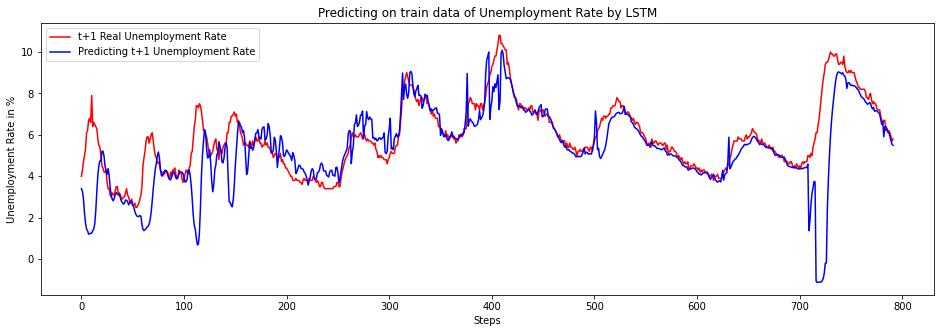

In [ ]:
lookback_step = 12
# One-step prediction on train data
optimal_lstm_train_result = optimal_lstm_model.predict(X_train)
#optimal_lstm_train_result = sc_lstm.inverse_transform(optimal_lstm_train_result)
y_train.reshape((792,1))
plt.figure(figsize=(16, 5)) 
plt.plot(y_train, color='red', label='t+1 Real Unemployment Rate')
#plt.plot(np.arange(lookback_step, len(optimal_lstm_train_result)),optimal_lstm_train_result, color='blue', label='Predicting t+1 Unemployment Rate')
plt.plot(optimal_lstm_train_result, color='blue', label='Predicting t+1 Unemployment Rate') 
plt.title('Predicting on train data of Unemployment Rate by LSTM')
plt.xlabel('Steps')
plt.ylabel('Unemployment Rate in %')
plt.legend()

### Plot graph between test data and forecasting by LSTM model

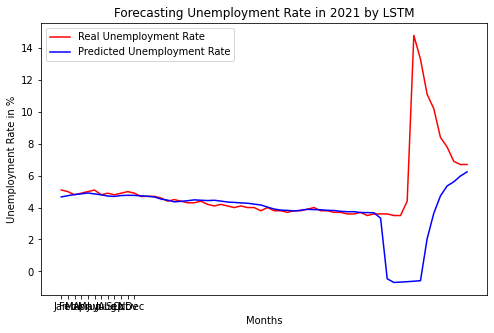

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(y_test, color='red',label='Real Unemployment Rate')
plt.plot(optimal_lstm_fcast, color='blue',label='Predicted Unemployment Rate')
plt.title('Forecasting Unemployment Rate from 2015-2021 by LSTM')
plt.xlabel('Months')
plt.ylabel('Unemployment Rate in %')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], 
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()
plt.show()


### Calculate MSE value with optimal hyperparameter

In [ ]:
print("Optimal value of neurons is:", optimal_lstm_neurons)
print("Optimal value of batch size is:", optimal_lstm_batch_size)
print("Optimal value of dropout is:", optimal_lstm_dropout)
print("The lowest MSE value of LSTM model is: {0:.3F}".format(min_mse_lstm))

Optimal value of neurons is: 5
Optimal value of batch size is: 24
Optimal value of dropout is: 0.05
The lowest MSE value of LSTM model is: 10.580


In [ ]:
#10years
print("Optimal value of neurons is:", optimal_lstm_neurons)
print("Optimal value of batch size is:", optimal_lstm_batch_size)
print("Optimal value of dropout is:", optimal_lstm_dropout)
print("The lowest MSE value of LSTM model is: {0:.3F}".format(min_mse_lstm))

Optimal value of neurons is: 10
Optimal value of batch size is: 6
Optimal value of dropout is: 0.5
The lowest MSE value of LSTM model is: 4.468


In [ ]:
#15years
print("Optimal value of neurons is:", optimal_lstm_neurons15)
print("Optimal value of batch size is:", optimal_lstm_batch_size15)
print("Optimal value of dropout is:", optimal_lstm_dropout15)
print("The lowest MSE value of LSTM model is: {0:.3F}".format(min_mse_lstm15))

Optimal value of neurons is: 10
Optimal value of batch size is: 6
Optimal value of dropout is: 0.5
The lowest MSE value of LSTM model is: 1179.057


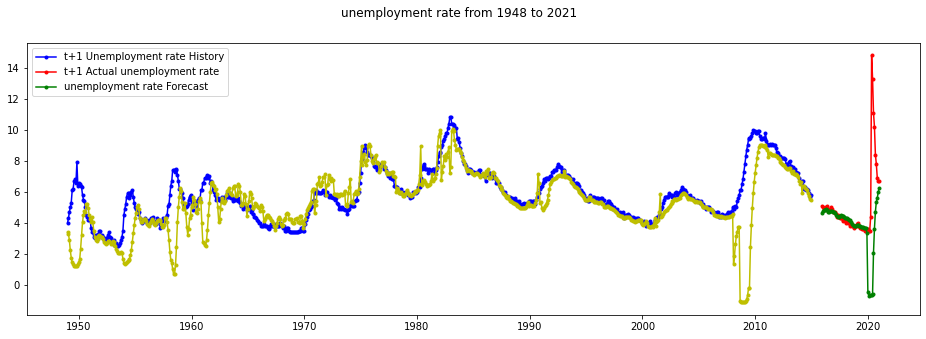

In [ ]:
#plot the training data, the test data and the forecast on the same plot
fig = plt.figure(figsize=(16, 5))
fig.suptitle('unemployment rate from 1948 to 2021')
past, = plt.plot(ts_train.index[11:], y_train, 'b.-', label='t+1 Unemployment rate History')
future, = plt.plot(ts_test.index[11:], y_test, 'r.-', label='t+1 Actual unemployment rate')
predicted_future, = plt.plot(ts_test.index[11:], optimal_lstm_fcast, 'g.-', label='unemployment rate Forecast')
predicted_past, = plt.plot(ts_train.index[11:], optimal_lstm_train_result, 'y.-', label='unemployment rate Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()

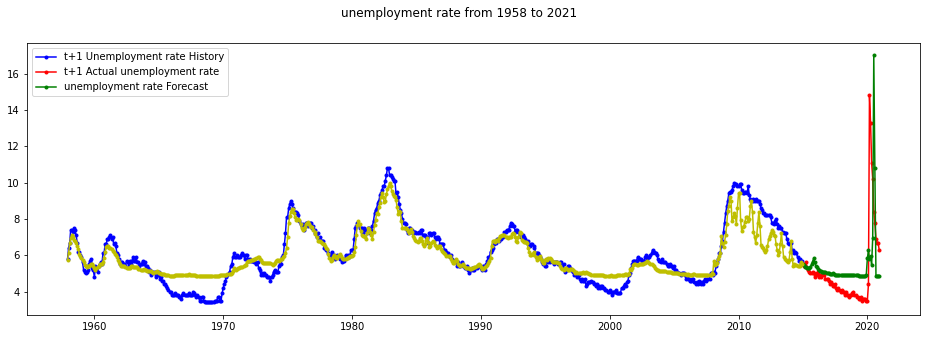

In [ ]:
#10years
#plot the training data, the test data and the forecast on the same plot
optimal_lstm_train_result10 = optimal_lstm_model.predict(X_train10)
fig = plt.figure(figsize=(16, 5))
fig.suptitle('unemployment rate from 1958 to 2021')
past, = plt.plot(ts_train.index[119:], y_train10, 'b.-', label='Unemployment rate History')
future, = plt.plot(df1.index[-72:], y_test10, 'r.-', label='Actual unemployment rate')
predicted_future, = plt.plot(df1.index[-72:], optimal_lstm_fcast, 'g.-', label='unemployment rate Forecast')
predicted_past, = plt.plot(ts_train.index[119:], optimal_lstm_train_result10, 'y.-', label='unemployment rate Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()

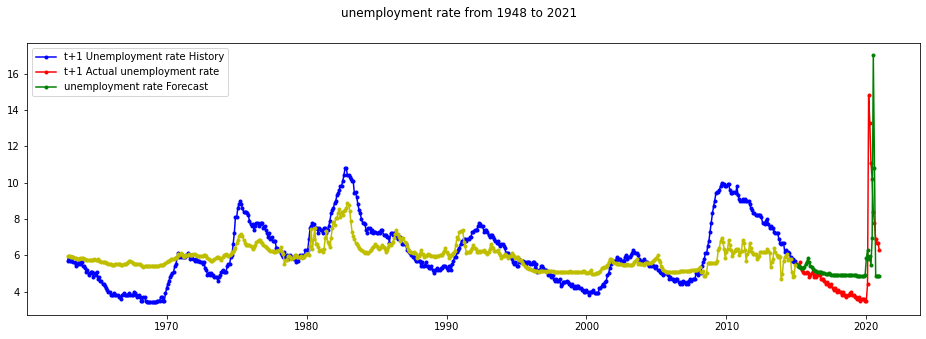

In [ ]:
#15years
#plot the training data, the test data and the forecast on the same plot
optimal_lstm_train_result15 = optimal_lstm_model5.predict(X_train15)
fig = plt.figure(figsize=(16, 5))
fig.suptitle('unemployment rate from 1948 to 2021')
past, = plt.plot(ts_train.index[179:], y_train15, 'b.-', label='t+1 Unemployment rate History')
future, = plt.plot(ts_test.index[-72:], y_test15, 'r.-', label='t+1 Actual unemployment rate')
predicted_future, = plt.plot(ts_test.index[-72:], optimal_lstm_fcast, 'g.-', label='unemployment rate Forecast')
predicted_past, = plt.plot(ts_train.index[179:], optimal_lstm_train_result15, 'y.-', label='unemployment rate Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()